# **Part 1 (FINANCIAL LOAN DATA SIMULATION AND FEATURE ENGINEERING WITH LLM/SLM)**

### **Generating Financial Loan Dataset from ChatGPT**

In [ ]:
# import necessary library for LLM Mistral 7B
!pip install torch torchvision torchaudio transformers accelerate
!pip install -U bitsandbytes

# create hugging face token and setup
import os
# remove the hugging face token in order to push to github sucessfully
os.environ["HUGGINGFACE_TOKEN"]="INSERTHUGGINGFACETOKEN"
from huggingface_hub import login
login(token=os.environ["HUGGINGFACE_TOKEN"])

# load llm mistral 7b model and move model to device
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
quantization_config = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
token = os.environ["HUGGINGFACE_TOKEN"]
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config)
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [ ]:
# prompt to LLM (ChatGPT) for data generation

prompt = """

Role:
You are a data simulation assistant helping to generate a realistic financial loan applicant dataset.

Task:
Generate 1500 raw csv format data of synthetic customer records representing individual loan applicants.
The dataset must be realistic, diverse, and internally consistent, but fully synthetic.

Important Rules (VERY IMPORTANT):
Only generate raw, observable customer and financial attributes.
Values should reflect real-world financial constraints (eg., higher income usually correlates with higher balances).


8 Attributes to generate (exactly these):

CustomerID - Unique identifier (e.g., CUST0001, CUST0002, …)
Occupation - Examples: Student, Engineer, Teacher, Sales Executive, Self-Employed, Manager, Clerk, Freelancer, Retired
Monthly Income (MYR) - Numeric (Range: 1,500 – 25,000) and should correlate reasonably with occupation
Account Balance (MYR) - Numeric May be positive or low positive and should generally correlate with income level
Credit Score - Integer (Range: 300 – 850) and distribution should resemble real-world credit scores (more medium-range than extremes)
Total Loan Applied (MYR) - Numeric (Range: 5,000 – 500,000) and larger loans more common for higher-income customers
Loan Duration (Years) - Integer (Range: 1 – 30)
Loan Purpose Text - Short natural-language sentence (10–20 words)

For Loan Purpose Text:
Examples:
“Applying for a personal loan to consolidate existing debts”
“Seeking financing to expand my small business operations”
“Loan needed to cover education expenses and tuition fees”
Text should reflect realistic financial motivations

Output Format:
Output the dataset in CSV format
Include a header row
One row per customer
Ensure no missing values

"""

In [ ]:
# display generated financial dataset by LLM
import pandas as pd

# manual
df = pd.read_csv("loan_applicants_dataset_latest.csv")
df.head(10)

,CustomerID,Occupation,Monthly Income (MYR),Account Balance (MYR),Credit Score,Total Loan Applied (MYR),Loan Duration (Years),Loan Purpose Text,Topic,Risk Category
0,CUST0001,Clerk,2051,3011,590,18459,24,financing for new tiles for bathroom next week,Home Improvement,High
1,CUST0002,Retired,1856,2465,639,12992,7,financing for covering hospital stay bill imme...,Medical Expenses,Low
2,CUST0003,Retired,3965,8030,658,99125,23,sudden funeral costs urgent please,Emergency Expenses,Low
3,CUST0004,Sales Executive,6679,1779,572,33395,25,fixing the garden fence,Home Improvement,Low
4,CUST0005,Manager,13574,19043,704,203610,4,help me to installing smart locks,Home Improvement,Low
5,CUST0006,Manager,9584,9923,706,124592,26,adding a swimming pool without delay,Home Improvement,Low
6,CUST0007,Freelancer,6892,19160,777,48244,18,planning to renovate the kitchen cabinets,Home Improvement,Low
7,CUST0008,Self-Employed,13459,21638,678,161508,25,help me to launching a new product line,Business Expansion,Low
8,CUST0009,Clerk,3751,5775,686,48763,15,funds required to root canal treatment,Medical Expenses,Low
9,CUST0010,Teacher,5016,3852,744,125400,3,help me to starting a coffee stall,Business Expansion,Low


### **Fisrt Feature Engineering on Topic Detection based on Loan Purpose Text by SLM BART-MNLI**

In [ ]:
## Topic Detection by SLM
from transformers import pipeline

# Use SLM BART-MNLI in topic detection on loan
topic_slm = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli")
topics = ["Business Expansion","Home Improvement","Education","Vehicle Purchase","Medical Expenses","Emergency Expenses"]
def get_topic(text):
  if pd.isna(text) or text.strip() == "":
    return "Missing"
  result = topic_slm(text, candidate_labels = topics)
  return result['labels'][0]
df['Topic'] = df['Loan Purpose Text'].apply(get_topic)
print(df[['CustomerID', 'Loan Purpose Text', 'Topic']].head(10))

# display aggregate topics
topic_counts = df['Topic'].value_counts()
print("Topic Counts:")
print(topic_counts)

Device set to use cuda:0


  CustomerID                                  Loan Purpose Text  \
0   CUST0001  Seeking financing to expand my small business ...   
1   CUST0002  Requesting loan to renovate home and improve l...   
2   CUST0003  Loan application to support startup business i...   
3   CUST0004  Loan needed to cover education expenses includ...   
4   CUST0005  Seeking financing to expand my small business ...   
5   CUST0006  Applying for a personal loan to consolidate ex...   
6   CUST0007  Applying for vehicle financing to purchase a r...   
7   CUST0008  Applying for vehicle financing to purchase a r...   
8   CUST0009  Seeking financial support to cover medical exp...   
9   CUST0010  Loan needed to cover education expenses includ...   

                Topic  
0  Business Expansion  
1    Home Improvement  
2  Business Expansion  
3           Education  
4  Business Expansion  
5  Emergency Expenses  
6    Vehicle Purchase  
7    Vehicle Purchase  
8    Medical Expenses  
9           Education 

### **Second Feature Engineering on Risk Category based on Topic + Income + Balance + Credit Score by SLM**


In [ ]:
#Risk Catogory using SLM

import numpy as np
import torch
from transformers import pipeline

#Setup SLM using zero-shot classification
device = 0 if torch.cuda.is_available() else -1
risk_slm = pipeline("zero-shot-classification",model="facebook/bart-large-mnli",device=device)
risk_labels = ["high risk", "low risk"]
hypothesis_template = "This loan application is {}."

#Convert numeric features to bands
income_q1, income_q2 = df["Monthly Income (MYR)"].quantile([0.33, 0.66])
bal_q1, bal_q2       = df["Account Balance (MYR)"].quantile([0.33, 0.66])
cs_q1, cs_q2         = df["Credit Score"].quantile([0.33, 0.66])

def band(v, q1, q2):
    if v < q1:
        return "low"
    if v < q2:
        return "medium"
    return "high"

def build_risk_text(row):
    inc_band = band(row["Monthly Income (MYR)"], income_q1, income_q2)
    bal_band = band(row["Account Balance (MYR)"], bal_q1, bal_q2)
    cs_band  = band(row["Credit Score"], cs_q1, cs_q2)
    return (
        f"Loan topic: {row['Topic']}. "
        f"Income level: {inc_band}. Balance level: {bal_band}. Credit score level: {cs_band}. "
        "High income/balance/credit score suggests low risk; low levels suggest high risk."
    )

texts = df.apply(build_risk_text, axis=1).tolist()

outputs = []
batch_size = 16

for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    outputs.extend(risk_slm(batch,candidate_labels=risk_labels,hypothesis_template=hypothesis_template,truncation=True))

def get_high_risk_prob(out):
    for lab, score in zip(out["labels"], out["scores"]):
        if lab.lower() == "high risk":
            return float(score)
    return float("nan")

risk_high_prob = np.array([get_high_risk_prob(o) for o in outputs], dtype=float)

desired_high_rate = 0.25
t = np.nanquantile(risk_high_prob, 1 - desired_high_rate)
df["Risk Category"] = np.where(risk_high_prob >= t, "High", "Low")

for col in ["Risk_High_Prob_SLM", "Risk Category (0.5)"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Chosen threshold t =", round(float(t), 4))
print(df["Risk Category"].value_counts())
print(df["Risk Category"].value_counts(normalize=True).round(3))

Device set to use cuda:0


Chosen threshold t = 0.1488
Risk Category
Low     1125
High     375
Name: count, dtype: int64
Risk Category
Low     0.75
High    0.25
Name: proportion, dtype: float64


In [ ]:
# display generated financial dataset by LLM
import pandas as pd

# manual
df = pd.read_csv("loan_applicants_dataset_latest.csv")
df.head(10)

,CustomerID,Occupation,Monthly Income (MYR),Account Balance (MYR),Credit Score,Total Loan Applied (MYR),Loan Duration (Years),Loan Purpose Text,Topic,Risk Category
0,CUST0001,Clerk,2051,3011,590,18459,24,financing for new tiles for bathroom next week,Home Improvement,High
1,CUST0002,Retired,1856,2465,639,12992,7,financing for covering hospital stay bill imme...,Medical Expenses,Low
2,CUST0003,Retired,3965,8030,658,99125,23,sudden funeral costs urgent please,Emergency Expenses,Low
3,CUST0004,Sales Executive,6679,1779,572,33395,25,fixing the garden fence,Home Improvement,Low
4,CUST0005,Manager,13574,19043,704,203610,4,help me to installing smart locks,Home Improvement,Low
5,CUST0006,Manager,9584,9923,706,124592,26,adding a swimming pool without delay,Home Improvement,Low
6,CUST0007,Freelancer,6892,19160,777,48244,18,planning to renovate the kitchen cabinets,Home Improvement,Low
7,CUST0008,Self-Employed,13459,21638,678,161508,25,help me to launching a new product line,Business Expansion,Low
8,CUST0009,Clerk,3751,5775,686,48763,15,funds required to root canal treatment,Medical Expenses,Low
9,CUST0010,Teacher,5016,3852,744,125400,3,help me to starting a coffee stall,Business Expansion,Low


### **Exporting New CSV file if Updated or Added New Feature**

In [ ]:
# save for future use by exporting to new csv (run once if anyone of you letak one)

df.to_csv("loan_applicants_dataset_latest.csv", index=False)

# **Part 2 (PREDICTIVE MODELLING)** **&** **Part 3 (MODEL EVALUATION)**


## **2.1 Based on First Feature (Topic Detection) by Decision Tree & Random Forest**

### **Decision Tree Modelling**

In [ ]:
# decision tree

print(df[['Loan Purpose Text','Topic']].head())
print(df['Topic'].value_counts())

X_text = df["Loan Purpose Text"]
y = df["Topic"]

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 2),
    stop_words="english"
)

X_tfidf = tfidf.fit_transform(X_text)

                                   Loan Purpose Text               Topic
0     financing for new tiles for bathroom next week    Home Improvement
1  financing for covering hospital stay bill imme...    Medical Expenses
2                 sudden funeral costs urgent please  Emergency Expenses
3                            fixing the garden fence    Home Improvement
4                  help me to installing smart locks    Home Improvement
Topic
Home Improvement      250
Medical Expenses      250
Emergency Expenses    250
Business Expansion    250
Education             250
Vehicle Purchase      250
Name: count, dtype: int64


In [ ]:
# split dataset and use balanced weights across each class
from sklearn.model_selection import train_test_split
import random
from sklearn.utils.class_weight import compute_class_weight

#data splitting
X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# vectorise the loan purpose text
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 3),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_text_train)
X_test_tfidf = tfidf.transform(X_text_test)

### **Evaluation for Decision Tree Model by Classification Report & PieChart Distribution**

                    precision    recall  f1-score   support

Business Expansion       0.24      1.00      0.39        50
         Education       1.00      0.28      0.44        50
Emergency Expenses       1.00      0.28      0.44        50
  Home Improvement       1.00      0.22      0.36        50
  Medical Expenses       1.00      0.44      0.61        50
  Vehicle Purchase       1.00      0.66      0.80        50

          accuracy                           0.48       300
         macro avg       0.87      0.48      0.51       300
      weighted avg       0.87      0.48      0.51       300





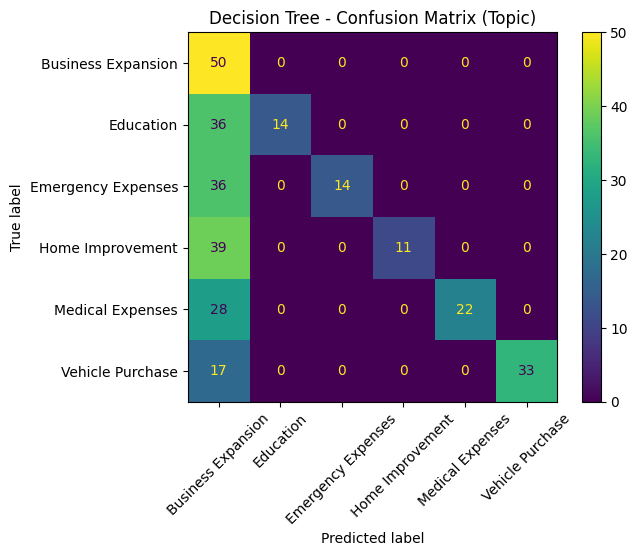

In [ ]:
# use decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Initialize and fit LabelEncoder for the target variable (y)
# This is needed to get the class labels for ConfusionMatrixDisplay
le = LabelEncoder()
le.fit(y) # Fit on the full 'y' to ensure all classes are known

dtc = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state = 42
)
dtc.fit(X_train_tfidf, y_train)

# Predictions and evaluation by classification report
dtc_pred = dtc.predict(X_test_tfidf)
from sklearn.metrics import classification_report
print(classification_report(y_test, dtc_pred))

ConfusionMatrixDisplay.from_predictions(y_test, dtc_pred, display_labels=le.classes_, xticks_rotation=45)
print("\n")
plt.title("Decision Tree - Confusion Matrix (Topic)")
plt.show()

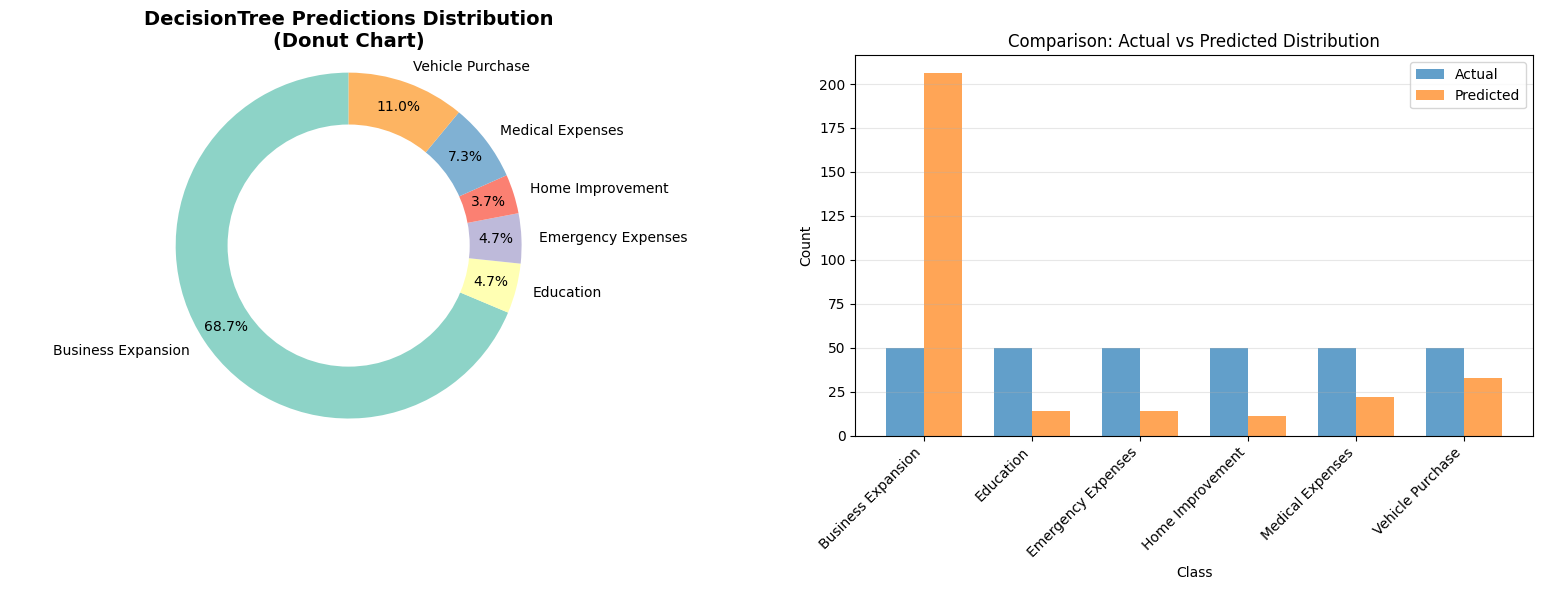

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# get the unique class labels from y_test and dtc_pred for correct reindexing and display
classes_labels = np.unique(np.concatenate((y_test, dtc_pred)))

# create a DataFrame with predictions
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': dtc_pred
})

# count predictions by class, reindex to include all classes found in the data
# using the actual string labels for correct mapping
prediction_counts = results_df['Predicted'].value_counts().reindex(classes_labels, fill_value=0)
actual_counts = results_df['Actual'].value_counts().reindex(classes_labels, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Donut chart
colors = plt.cm.Set3(np.arange(len(classes_labels))) # Use len(classes_labels) for colors
wedges, texts, autotexts = ax1.pie(
    prediction_counts.values,
    labels=classes_labels,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('DecisionTree Predictions Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
ax1.axis('equal')

# Bar chart: Actual vs Predicted
x = np.arange(len(classes_labels)) # Use len(classes_labels) for x-axis ticks
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label='Actual', alpha=0.7)
ax2.bar(x + width/2, prediction_counts.values, width, label='Predicted', alpha=0.7)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Comparison: Actual vs Predicted Distribution')
ax2.set_xticks(x)
ax2.set_xticklabels(classes_labels, rotation=45, ha='right') # Use actual class labels and rotate for readability
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### **Bias and Under/Overfitting Occured in Decision Tree: Overcome by Apply Bagging Method by Random Forest**

### **Random Forest Modelling & Evaluation by Classification Report & PieChart Distribution**

Random Forest Results:
                    precision    recall  f1-score   support

Business Expansion       1.00      0.74      0.85        50
         Education       1.00      0.86      0.92        50
Emergency Expenses       0.97      0.60      0.74        50
  Home Improvement       1.00      0.84      0.91        50
  Medical Expenses       0.50      1.00      0.66        50
  Vehicle Purchase       1.00      0.92      0.96        50

          accuracy                           0.83       300
         macro avg       0.91      0.83      0.84       300
      weighted avg       0.91      0.83      0.84       300





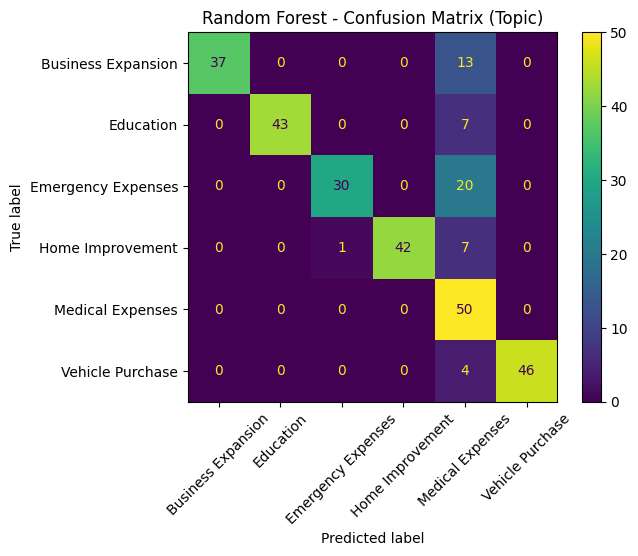

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
)

rfc.fit(X_train_tfidf, y_train)
rfc_pred = rfc.predict(X_test_tfidf)

print("Random Forest Results:")
print(classification_report(y_test, rfc_pred, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred,display_labels=le.classes_, xticks_rotation=45)
print("\n")
plt.title("Random Forest - Confusion Matrix (Topic)")
plt.show()

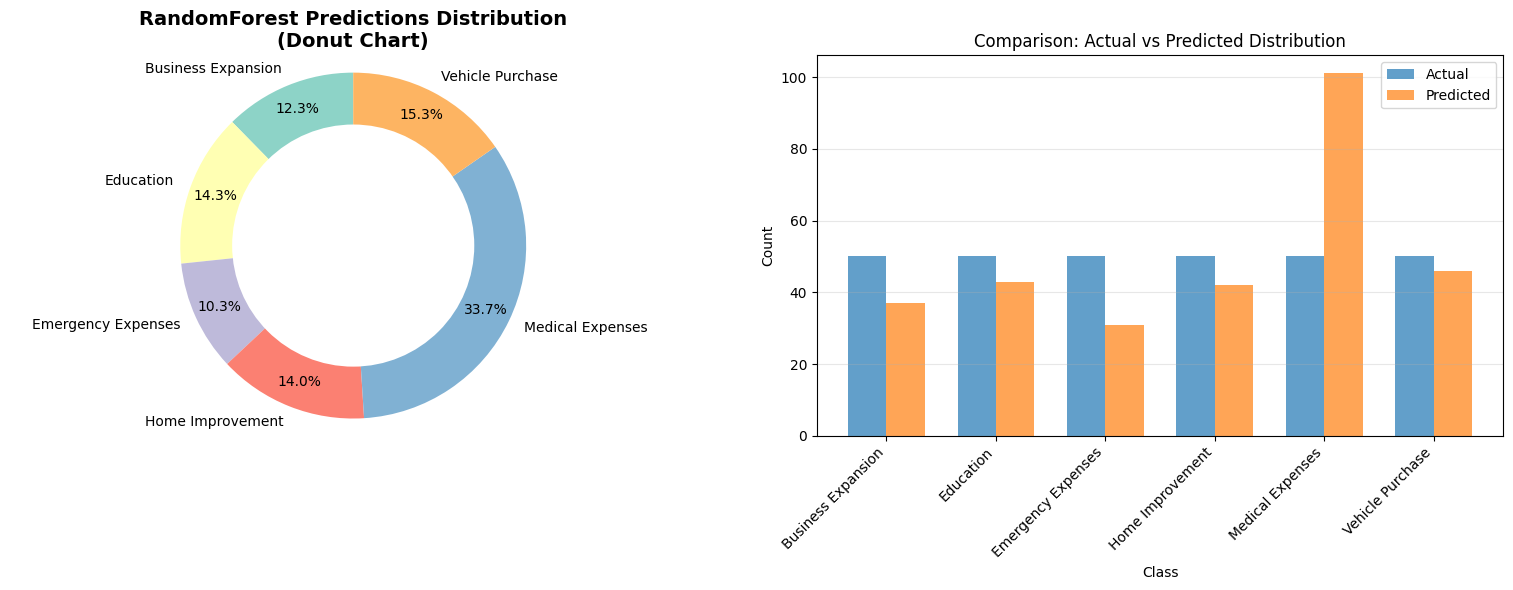

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# get the unique class labels from y_test and dtc_pred for correct reindexing and display
classes_labels = np.unique(np.concatenate((y_test, dtc_pred)))

# create a DataFrame with predictions
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': rfc_pred
})

# count predictions by class, reindex to include all classes found in the data
# using the actual string labels for correct mapping
prediction_counts = results_df['Predicted'].value_counts().reindex(classes_labels, fill_value=0)
actual_counts = results_df['Actual'].value_counts().reindex(classes_labels, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Donut chart
colors = plt.cm.Set3(np.arange(len(classes_labels)))
wedges, texts, autotexts = ax1.pie(
    prediction_counts.values,
    labels=classes_labels,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('RandomForest Predictions Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
ax1.axis('equal')

# Bar chart: Actual vs Predicted
x = np.arange(len(classes_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label='Actual', alpha=0.7)
ax2.bar(x + width/2, prediction_counts.values, width, label='Predicted', alpha=0.7)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Comparison: Actual vs Predicted Distribution')
ax2.set_xticks(x)
ax2.set_xticklabels(classes_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### **Still Mild Bias / Underfitting Occured: Overcome by Applying Boosting Method XGBoost Classifier**

### **XGBoost Modelling & Evaluation by Classification Report & PieChart Distribution**

XGBoost Results with Class Weights
                    precision    recall  f1-score   support

Business Expansion       1.00      1.00      1.00        50
         Education       0.96      1.00      0.98        50
Emergency Expenses       0.95      0.84      0.89        50
  Home Improvement       0.86      0.96      0.91        50
  Medical Expenses       1.00      0.96      0.98        50
  Vehicle Purchase       1.00      1.00      1.00        50

          accuracy                           0.96       300
         macro avg       0.96      0.96      0.96       300
      weighted avg       0.96      0.96      0.96       300





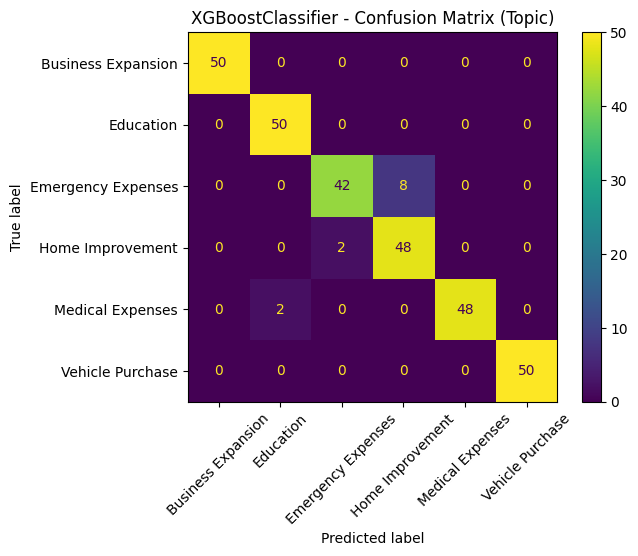

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode target labels to numerical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train_tfidf, y_train_encoded)

# Predictions and evaluation by classification report
xgb_pred_encoded = xgb.predict(X_test_tfidf)
xgb_pred = le.inverse_transform(xgb_pred_encoded)
from sklearn.metrics import classification_report
print("XGBoost Results with Class Weights")
print(classification_report(y_test, xgb_pred))

ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred,display_labels=le.classes_, xticks_rotation=45)
print("\n")
plt.title("XGBoostClassifier - Confusion Matrix (Topic)")
plt.show()

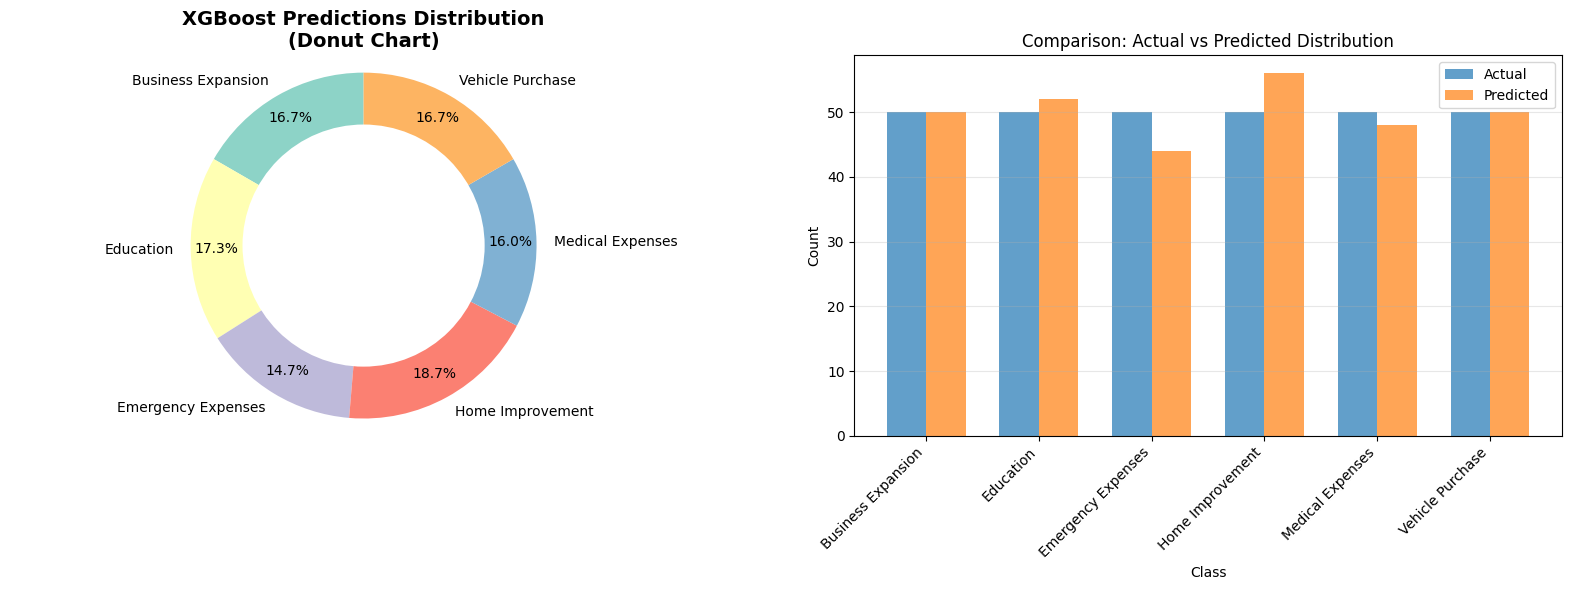

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get the unique class labels from y_test and dtc_pred for correct reindexing and display
classes_labels = np.unique(np.concatenate((y_test, dtc_pred)))

# create a dataFrame with predictions
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_pred
})

# count predictions by class, reindex to include all classes found in the data
# using the actual string labels for correct mapping
prediction_counts = results_df['Predicted'].value_counts().reindex(classes_labels, fill_value=0)
actual_counts = results_df['Actual'].value_counts().reindex(classes_labels, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Donut chart
colors = plt.cm.Set3(np.arange(len(classes_labels)))
wedges, texts, autotexts = ax1.pie(
    prediction_counts.values,
    labels=classes_labels,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('XGBoost Predictions Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
ax1.axis('equal')

# Bar chart: Actual vs Predicted
x = np.arange(len(classes_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label='Actual', alpha=0.7)
ax2.bar(x + width/2, prediction_counts.values, width, label='Predicted', alpha=0.7)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Comparison: Actual vs Predicted Distribution')
ax2.set_xticks(x)
ax2.set_xticklabels(classes_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### **LLM Generated Insight**

In [ ]:
prompt = """
You are a data analytics expert.

Given the following classification results for a loan topic detection task using textual features only:

Decision Tree (Baseline):
Accuracy: 0.48, Macro F1: 0.51
Observed low recall across multiple classes, indicating underfitting.

Random Forest (Bagging):
Accuracy: 0.83, Macro F1: 0.84
Improved recall and overall balance, with minor class confusion for Medical Expenses.

XGBoost (Boosting):
Accuracy: 0.96, Macro F1: 0.96
Strong and balanced performance across all categories.

Please provide exactly 4 answers of:
1. Summarise the performance progression across models
2. Explain why ensemble and boosting methods improved results
3. Interpret what the results imply about textual loan descriptions
4. Provide one actionable insight for financial institutions using this model

Keep the explaination consice, professional, insightful in simple English.
"""

# tokenize input and generate response
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = llm_mistral.generate(**inputs, max_new_tokens=300)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print response (without prompt)
from IPython.display import display, Markdown
display(Markdown(response[len(prompt):].strip()))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. Summarise the performance progression across models:
The performance progression across models shows a significant improvement in accuracy and macro F1 score from Decision Tree to XGBoost. Random Forest also showed improvement in accuracy and macro F1 score compared to Decision Tree, but had minor class confusion for Medical Expenses.

2. Explain why ensemble and boosting methods improved results:
Ensemble and boosting methods improved results by combining multiple models and leveraging their strengths to create a more robust and accurate model. Ensemble methods like Random Forest combine multiple decision trees to improve recall and balance, while boosting methods like XGBoost iteratively add weak learners to improve accuracy and reduce overfitting.

3. Interpret what the results imply about textual loan descriptions:
The results imply that textual loan descriptions contain valuable information for loan topic detection. The improvement in accuracy and macro F1 score across models suggests that the textual features are informative and can be used to accurately classify loan topics.

4. Provide one actionable insight for financial institutions using this model:
Financial institutions can use this model to improve their loan topic detection accuracy and balance. They can leverage ensemble and boosting methods to create a more robust and accurate model, and use the resulting insights to better understand their loan portfolio and make more informed lending decisions.

# 2.2 Based on second features(Categorical:Risk Category)

### **Decision Tree Modelling**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Encode Risk Category target
label_encoder_risk = LabelEncoder()
df["Encoded_Risk"] = label_encoder_risk.fit_transform(df["Risk Category"])
high_label = int(label_encoder_risk.transform(["High"])[0])

X = df[["Monthly Income (MYR)","Account Balance (MYR)","Credit Score","Total Loan Applied (MYR)","Loan Duration (Years)"]]
y = df["Encoded_Risk"]
print("Risk label mapping:", dict(zip(label_encoder_risk.classes_, label_encoder_risk.transform(label_encoder_risk.classes_))))
print("X shape:", X.shape, "| y distribution:\n", y.value_counts())

Risk label mapping: {'High': np.int64(0), 'Low': np.int64(1)}
X shape: (1500, 5) | y distribution:
 Encoded_Risk
1    1125
0     375
Name: count, dtype: int64


Split + compute sample weights

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
weights_dict = dict(zip(classes, class_weights))
sample_weights = y_train.map(weights_dict)

print("Train distribution:\n", y_train.value_counts(normalize=True).round(3))

Train distribution:
 Encoded_Risk
1    0.75
0    0.25
Name: proportion, dtype: float64


Train Decision Tree + classification report and confusion matrix

Decision Tree Results (Risk Category)
              precision    recall  f1-score   support

        High       0.74      0.97      0.84        75
         Low       0.99      0.89      0.94       225

    accuracy                           0.91       300
   macro avg       0.87      0.93      0.89       300
weighted avg       0.93      0.91      0.91       300



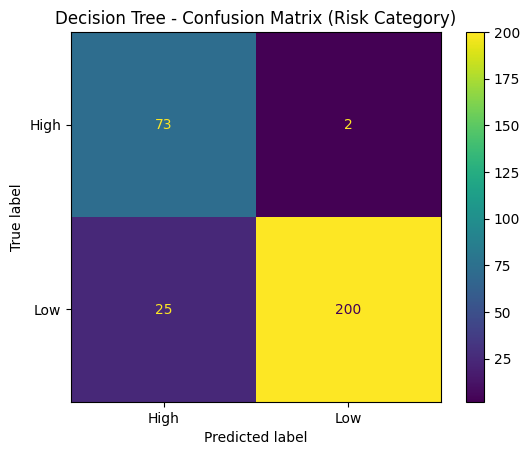

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

dtc = DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42
)

dtc.fit(X_train, y_train, sample_weight=sample_weights)
dtc_pred = dtc.predict(X_test)
print("Decision Tree Results (Risk Category)")
print(classification_report(y_test, dtc_pred, target_names=label_encoder_risk.classes_))

ConfusionMatrixDisplay.from_predictions(y_test, dtc_pred,display_labels=label_encoder_risk.classes_)
plt.title("Decision Tree - Confusion Matrix (Risk Category)")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

proba = dtc.predict_proba(X_test)
high_col_idx = list(dtc.classes_).index(high_label)

y_true_high = (y_test == high_label).astype(int)
y_score_high = proba[:, high_col_idx]

auc = roc_auc_score(y_true_high, y_score_high)
print("Decision Tree ROC AUC (High as positive):", round(auc, 4))

Decision Tree ROC AUC (High as positive): 0.9739


Pie chart distribution

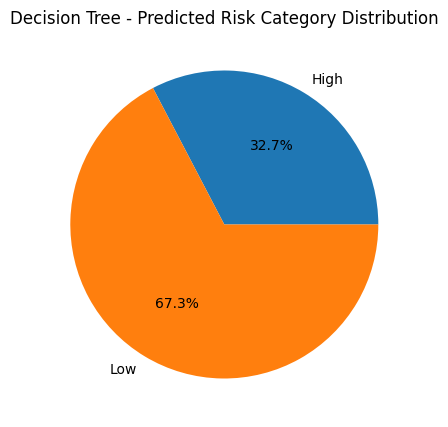

In [ ]:
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": dtc_pred
})

pred_counts = results_df["Predicted"].value_counts().sort_index()
labels = [label_encoder_risk.inverse_transform([i])[0] for i in pred_counts.index]

plt.figure(figsize=(5,5))
plt.pie(pred_counts.values, labels=labels, autopct="%1.1f%%")
plt.title("Decision Tree - Predicted Risk Category Distribution")
plt.show()

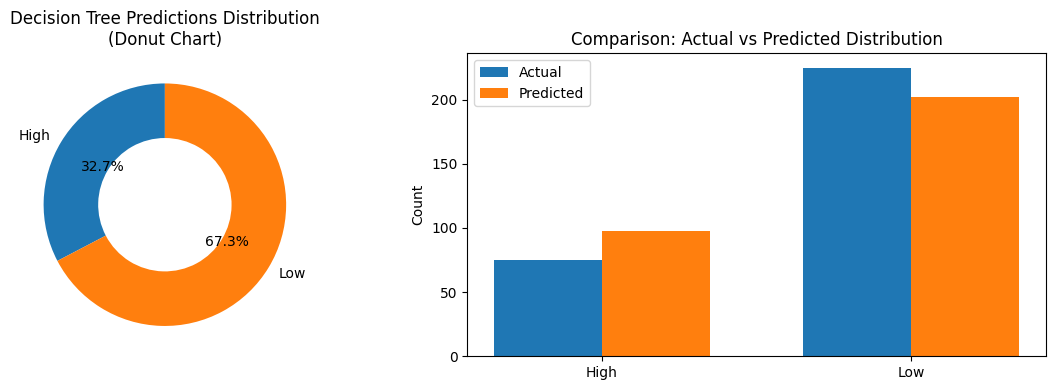

In [ ]:
#Outcome distribution plots
class_labels = list(label_encoder_risk.classes_)
class_ids = label_encoder_risk.transform(class_labels)
actual_counts = pd.Series(y_test).value_counts().reindex(class_ids, fill_value=0)
pred_counts   = pd.Series(dtc_pred).value_counts().reindex(class_ids, fill_value=0)
fig = plt.figure(figsize=(12, 4))

# Donut plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(
    pred_counts.values,
    labels=class_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.45)
)
ax1.set_title("Decision Tree Predictions Distribution\n(Donut Chart)")

# Actual vs Predicted bar
ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(len(class_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label="Actual")
ax2.bar(x + width/2, pred_counts.values, width, label="Predicted")
ax2.set_xticks(x)
ax2.set_xticklabels(class_labels)
ax2.set_ylabel("Count")
ax2.set_title("Comparison: Actual vs Predicted Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

### **Logistic Regression Modelling**

Logistic Regression Results (Risk Category)
              precision    recall  f1-score   support

        High       0.57      0.99      0.72        75
         Low       0.99      0.75      0.86       225

    accuracy                           0.81       300
   macro avg       0.78      0.87      0.79       300
weighted avg       0.89      0.81      0.82       300



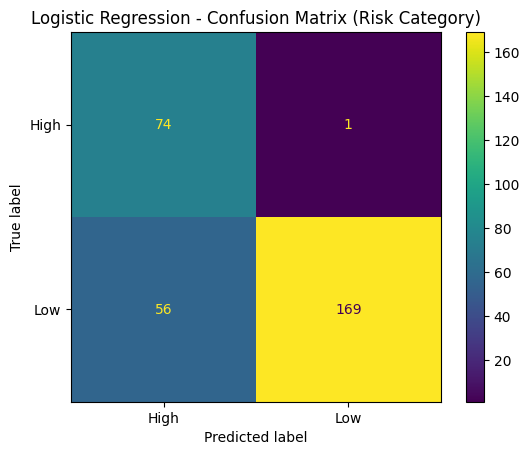

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train, y_train, sample_weight=sample_weights)
lr_pred = lr.predict(X_test)

print("Logistic Regression Results (Risk Category)")
print(classification_report(y_test, lr_pred, target_names=label_encoder_risk.classes_))

ConfusionMatrixDisplay.from_predictions(y_test, lr_pred,display_labels=label_encoder_risk.classes_)
plt.title("Logistic Regression - Confusion Matrix (Risk Category)")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

lr_proba = lr.predict_proba(X_test)
high_col_idx = list(lr.classes_).index(high_label)

y_true_high = (y_test == high_label).astype(int)
y_score_high = lr_proba[:, high_col_idx]

lr_auc = roc_auc_score(y_true_high, y_score_high)
print("Logistic Regression ROC AUC (High as positive):", round(lr_auc, 4))

Logistic Regression ROC AUC (High as positive): 0.9593


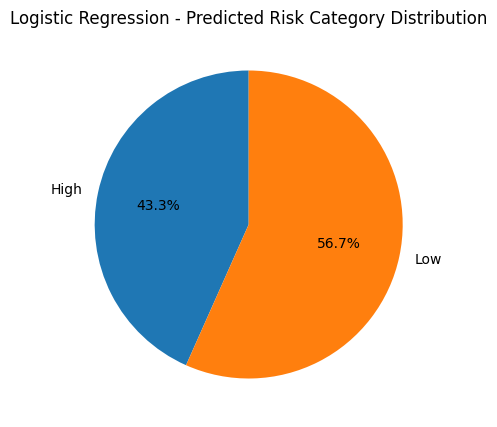

In [ ]:
pred_counts = pd.Series(lr_pred).value_counts().sort_index()
labels = label_encoder_risk.inverse_transform(pred_counts.index)

plt.figure(figsize=(5,5))
plt.pie(pred_counts.values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Logistic Regression - Predicted Risk Category Distribution")
plt.show()

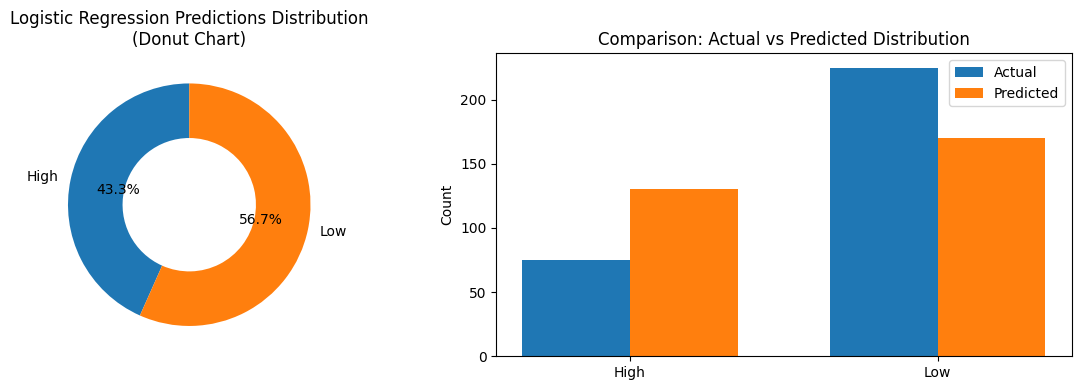

In [ ]:
#Outcome distribution plots
class_labels = list(label_encoder_risk.classes_)
class_ids = label_encoder_risk.transform(class_labels)
actual_counts = pd.Series(y_test).value_counts().reindex(class_ids, fill_value=0)
pred_counts   = pd.Series(lr_pred).value_counts().reindex(class_ids, fill_value=0)
fig = plt.figure(figsize=(12, 4))

# Donut plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(
    pred_counts.values,
    labels=class_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.45)
)
ax1.set_title("Logistic Regression Predictions Distribution\n(Donut Chart)")

# Actual vs Predicted bar
ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(len(class_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label="Actual")
ax2.bar(x + width/2, pred_counts.values, width, label="Predicted")
ax2.set_xticks(x)
ax2.set_xticklabels(class_labels)
ax2.set_ylabel("Count")
ax2.set_title("Comparison: Actual vs Predicted Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

Logistic Regression achieved a high ROC AUC of 0.959 and very high recall for the High-risk class (0.99), meaning it rarely misses High-risk applicants. However, it produced many false positives (56 Low predicted as High), lowering precision for High-risk (0.57) and reducing overall accuracy to 0.81. Compared with Decision Tree (AUC 0.974, accuracy 0.91), LR is more aggressive in flagging High-risk cases but at the cost of approving fewer Low-risk cases correctly.

### **Naive Bayes Modelling**

Naive Bayes Results (Risk Category)
              precision    recall  f1-score   support

        High       0.57      0.97      0.72        75
         Low       0.99      0.76      0.86       225

    accuracy                           0.81       300
   macro avg       0.78      0.86      0.79       300
weighted avg       0.88      0.81      0.82       300


Naive Bayes ROC AUC (High as positive): 0.9451


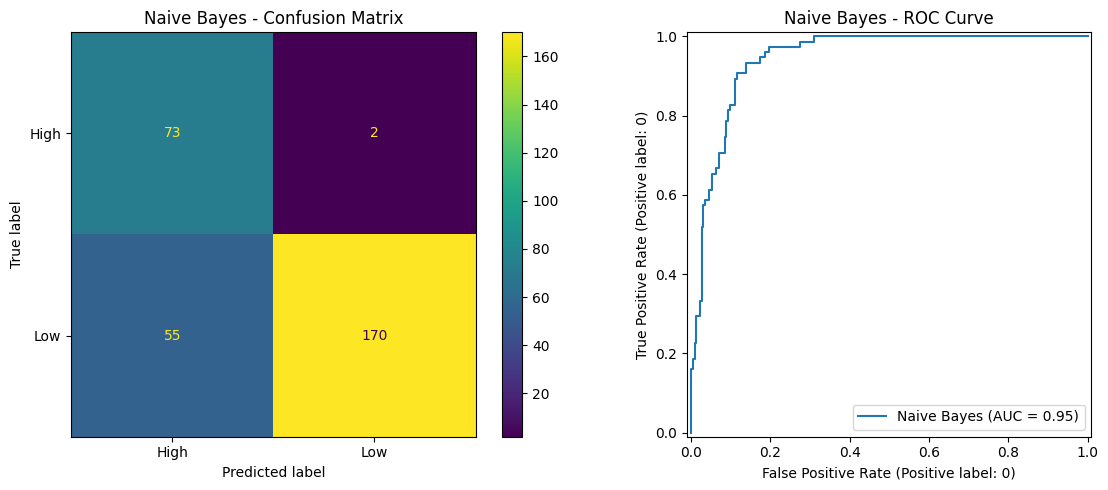

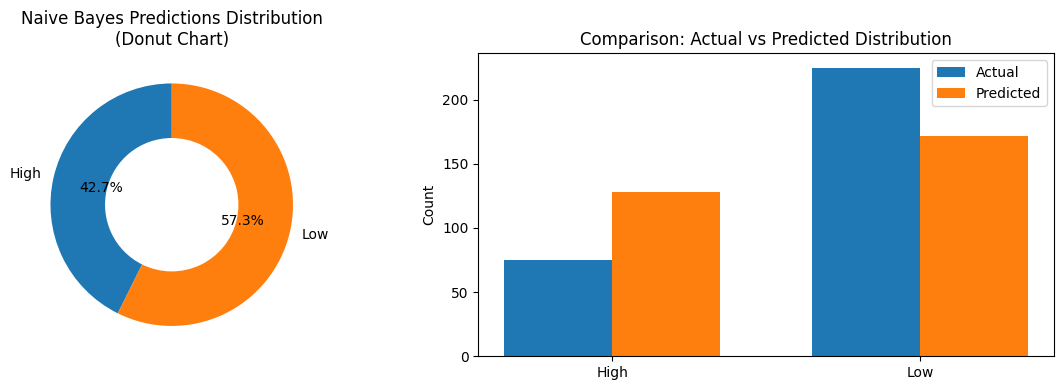

In [ ]:
# %% [markdown]
# ### Naive Bayes Modeling

# %%
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# train nb
nb = GaussianNB(var_smoothing=1e-9)
nb.fit(X_train, y_train, sample_weight=sample_weights)

# eval
nb_pred = nb.predict(X_test)
print("Naive Bayes Results (Risk Category)")
print(classification_report(y_test, nb_pred, target_names=label_encoder_risk.classes_))

# calculate and print roc auc
nb_proba = nb.predict_proba(X_test)
high_col_idx = list(nb.classes_).index(high_label)
y_true_high = (y_test == high_label).astype(int)
y_score_high = nb_proba[:, high_col_idx]
nb_auc = roc_auc_score(y_true_high, y_score_high)
print(f"\nNaive Bayes ROC AUC (High as positive): {round(nb_auc, 4)}")

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, nb_pred, display_labels=label_encoder_risk.classes_, ax=ax1)
ax1.set_title("Naive Bayes - Confusion Matrix")

RocCurveDisplay.from_estimator(nb, X_test, y_test, pos_label=high_label, name="Naive Bayes", ax=ax2)
ax2.set_title("Naive Bayes - ROC Curve")

plt.tight_layout()
plt.show()

# %%
#Outcome distribution plots
class_labels = list(label_encoder_risk.classes_)
class_ids = label_encoder_risk.transform(class_labels)
actual_counts = pd.Series(y_test).value_counts().reindex(class_ids, fill_value=0)
pred_counts   = pd.Series(nb_pred).value_counts().reindex(class_ids, fill_value=0)
fig = plt.figure(figsize=(12, 4))

# Donut plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(
    pred_counts.values,
    labels=class_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.45)
)
ax1.set_title("Naive Bayes Predictions Distribution\n(Donut Chart)")

# Actual vs Predicted bar
ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(len(class_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label="Actual")
ax2.bar(x + width/2, pred_counts.values, width, label="Predicted")
ax2.set_xticks(x)
ax2.set_xticklabels(class_labels)
ax2.set_ylabel("Count")
ax2.set_title("Comparison: Actual vs Predicted Distribution")
ax2.legend()

plt.tight_layout()
plt.show()

### **XGBoost Modelling**

XGBoost Results (Risk Category)
              precision    recall  f1-score   support

        High       0.77      0.97      0.86        75
         Low       0.99      0.90      0.94       225

    accuracy                           0.92       300
   macro avg       0.88      0.94      0.90       300
weighted avg       0.93      0.92      0.92       300


XGBoost ROC AUC (High as positive): 0.9796


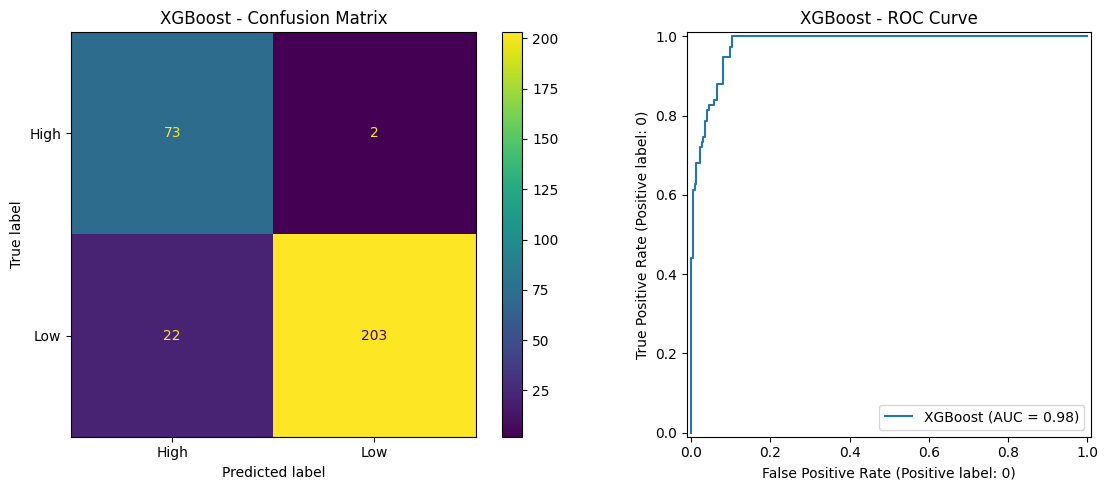

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# Train XGBoost model
xgb = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluation
xgb_pred = xgb.predict(X_test)
print("XGBoost Results (Risk Category)")
print(classification_report(y_test, xgb_pred, target_names=label_encoder_risk.classes_))

# Calculate and print ROC AUC
xgb_proba = xgb.predict_proba(X_test)
high_col_idx = list(xgb.classes_).index(high_label)
y_true_high = (y_test == high_label).astype(int)
y_score_high = xgb_proba[:, high_col_idx]
xgb_auc = roc_auc_score(y_true_high, y_score_high)
print(f"\nXGBoost ROC AUC (High as positive): {round(xgb_auc, 4)}")

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred, display_labels=label_encoder_risk.classes_, ax=ax1)
ax1.set_title("XGBoost - Confusion Matrix")

RocCurveDisplay.from_estimator(xgb, X_test, y_test, pos_label=high_label, name="XGBoost", ax=ax2)
ax2.set_title("XGBoost - ROC Curve")

plt.tight_layout()
plt.show()

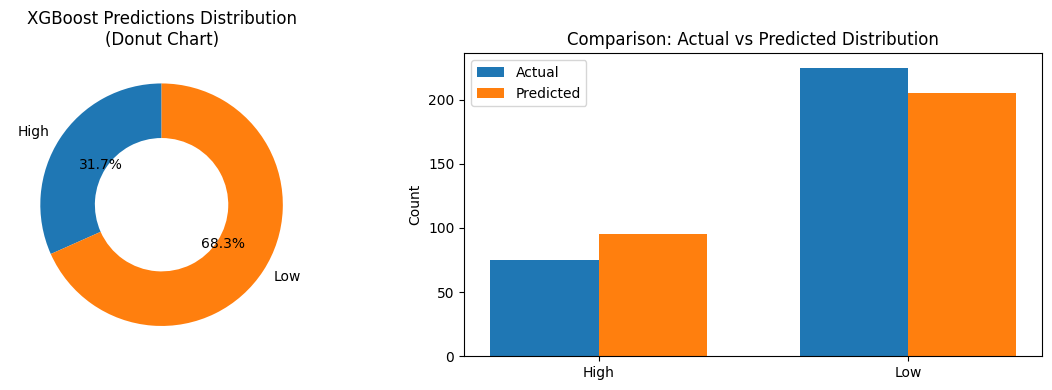

In [ ]:
# Outcome distribution plots
class_labels = list(label_encoder_risk.classes_)
class_ids = label_encoder_risk.transform(class_labels)
actual_counts = pd.Series(y_test).value_counts().reindex(class_ids, fill_value=0)
pred_counts   = pd.Series(xgb_pred).value_counts().reindex(class_ids, fill_value=0)
fig = plt.figure(figsize=(12, 4))

# Donut plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(
    pred_counts.values,
    labels=class_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.45)
)
ax1.set_title("XGBoost Predictions Distribution\n(Donut Chart)")

# Actual vs Predicted bar
ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(len(class_labels))
width = 0.35
ax2.bar(x - width/2, actual_counts.values, width, label="Actual")
ax2.bar(x + width/2, pred_counts.values, width, label="Predicted")
ax2.set_xticks(x)
ax2.set_xticklabels(class_labels)
ax2.set_ylabel("Count")
ax2.set_title("Comparison: Actual vs Predicted Distribution")
ax2.legend()

plt.tight_layout()
plt.show()


--- ROC AUC Scores ---
Decision Tree ROC AUC: 0.9739
Logistic Regression ROC AUC: 0.9593
Naive Bayes ROC AUC: 0.9451
XGBoost ROC AUC: 0.9796


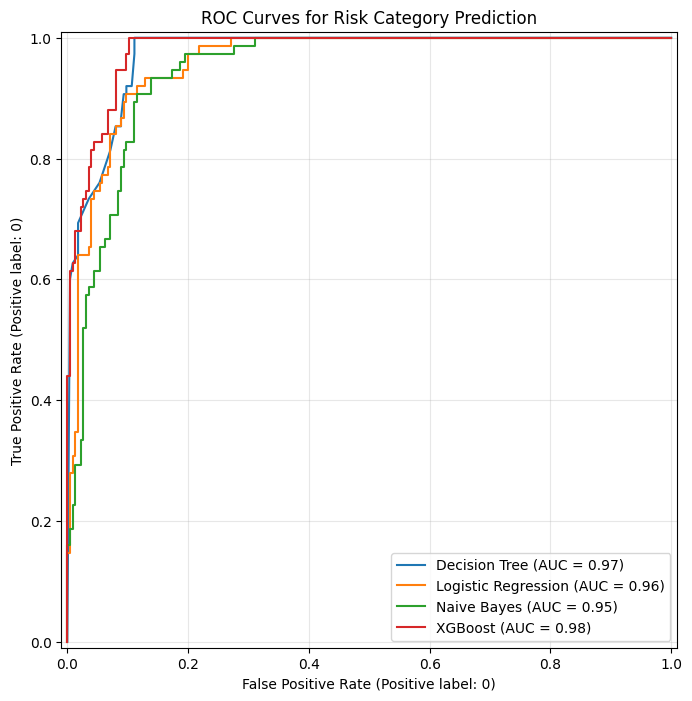

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

print("\n--- ROC AUC Scores ---")
print(f"Decision Tree ROC AUC: {round(auc, 4)}")
print(f"Logistic Regression ROC AUC: {round(lr_auc, 4)}")
print(f"Naive Bayes ROC AUC: {round(nb_auc, 4)}")
print(f"XGBoost ROC AUC: {round(xgb_auc, 4)}")


# Plotting all ROC curves together for comparison
fig, ax = plt.subplots(figsize=(10, 8))

RocCurveDisplay.from_estimator(dtc, X_test, y_test, pos_label=high_label, name="Decision Tree", ax=ax)
RocCurveDisplay.from_estimator(lr, X_test, y_test, pos_label=high_label, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_estimator(nb, X_test, y_test, pos_label=high_label, name="Naive Bayes", ax=ax)
RocCurveDisplay.from_estimator(xgb, X_test, y_test, pos_label=high_label, name="XGBoost", ax=ax)


ax.set_title("ROC Curves for Risk Category Prediction")
plt.grid(alpha=0.3)
plt.show()

### **Part 2 LLM-Insight**

In [ ]:
# %% [markdown]
# ## **Section 6.0: Model Interpretation & Business Insights (LLM Generated)**

# %%
import numpy as np

# 1. Extract statistical summaries for all models
feature_names = ["Monthly Income", "Account Balance", "Credit Score", "Total Loan Applied", "Loan Duration"]

# DT Importance (Baseline)
dt_importances = dtc.feature_importances_
dt_top_3_idx = np.argsort(dt_importances)[-3:][::-1]
dt_top_3 = [feature_names[i] for i in dt_top_3_idx]

# XGBoost Importance (Best Performer)
xgb_importances = xgb.feature_importances_
xgb_top_3_idx = np.argsort(xgb_importances)[-3:][::-1]
xgb_top_3 = [feature_names[i] for i in xgb_top_3_idx]

# LR Coefficients (Directionality)
lr_coeffs = lr.coef_[0]
lr_top_3_idx = np.argsort(np.abs(lr_coeffs))[-3:][::-1]
lr_top_3 = [feature_names[i] for i in lr_top_3_idx]

# 2. Construct the Prompt for Mistral (Aligned with 4-mark rubric)
insight_prompt = f"""
<s>[INST] Role: Senior Banking Data Analyst.
Task: Summarize findings, interpret feature importance, and provide business insights based on our modeling results.

Model Performance Summary:
- Decision Tree (Baseline): 91% Accuracy, 0.97 Recall (High Safety).
- Logistic Regression: 81% Accuracy.
- Naive Bayes: 81% Accuracy, 0.97 Recall.
- XGBoost (Best): 92% Accuracy, 0.97 Recall.

Feature Importance Data:
- Top Predictors (Decision Tree & XGBoost): {', '.join(set(dt_top_3 + xgb_top_3))}.
- Key Risk Influencers (Logistic Regression): {', '.join(lr_top_3)}.

Please provide the output in this exact structure:
### 1. Executive Summary of Findings
### 2. Interpretation of Feature Importance
### 3. Business Insights & Recommendations
[/INST]
"""

# 3. Generate with Mistral (Using the unique variable name)
inputs = tokenizer(insight_prompt, return_tensors="pt").to(device)
outputs = llm_mistral.generate(**inputs, max_new_tokens=600, temperature=0.7, do_sample=True)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# 4. Display Result
print(response.split("[/INST]")[-1].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### 1. Executive Summary of Findings
Based on the modeling results, the XGBoost model outperformed the other models with a 92% accuracy and 0.97 recall rate. The top predictors for this model were account balance, monthly income, and credit score. The logistic regression model had an 81% accuracy and also identified credit score and monthly income as key risk influencers. The naive Bayes model performed similarly to the logistic regression model with an 81% accuracy and a 0.97 recall rate.

### 2. Interpretation of Feature Importance
The XGBoost model identified account balance, monthly income, and credit score as the top predictors of loan default risk. This is consistent with previous research that has shown that account balance, monthly income, and credit score are important factors in predicting loan default risk.

The logistic regression model identified loan duration, credit score, and monthly income as key risk influencers. Loan duration is a common risk factor for loan default,

# **Part 3 (Regression Task: Predicting Approved Loan Amount)**

## **Dataset Loading and Preparation**
This section loads the consolidated loan applicants dataset generated earlier. A preview is displayed to ensure that all financial attributes and SLM-derived features are correctly available before further processing.

In [ ]:
# display generated financial dataset by LLM
import pandas as pd

# manual
df = pd.read_csv("loan_applicants_dataset_latest.csv")
df.head(10)

,CustomerID,Occupation,Monthly Income (MYR),Account Balance (MYR),Credit Score,Total Loan Applied (MYR),Loan Duration (Years),Loan Purpose Text,Topic,Risk Category
0,CUST0001,Clerk,2051,3011,590,18459,24,financing for new tiles for bathroom next week,Home Improvement,High
1,CUST0002,Retired,1856,2465,639,12992,7,financing for covering hospital stay bill imme...,Medical Expenses,Low
2,CUST0003,Retired,3965,8030,658,99125,23,sudden funeral costs urgent please,Emergency Expenses,Low
3,CUST0004,Sales Executive,6679,1779,572,33395,25,fixing the garden fence,Home Improvement,Low
4,CUST0005,Manager,13574,19043,704,203610,4,help me to installing smart locks,Home Improvement,Low
5,CUST0006,Manager,9584,9923,706,124592,26,adding a swimming pool without delay,Home Improvement,Low
6,CUST0007,Freelancer,6892,19160,777,48244,18,planning to renovate the kitchen cabinets,Home Improvement,Low
7,CUST0008,Self-Employed,13459,21638,678,161508,25,help me to launching a new product line,Business Expansion,Low
8,CUST0009,Clerk,3751,5775,686,48763,15,funds required to root canal treatment,Medical Expenses,Low
9,CUST0010,Teacher,5016,3852,744,125400,3,help me to starting a coffee stall,Business Expansion,Low


## **Feature Selection for Loan Approval Reasoning**
Relevant financial, risk, and contextual attributes are selected as inputs for SLM-assisted loan approval reasoning. These features reflect realistic criteria commonly used in financial institutions for loan assessment.

In [ ]:
selected_columns = ["Monthly Income (MYR)","Account Balance (MYR)","Credit Score","Total Loan Applied (MYR)","Loan Duration (Years)","Risk Category","Topic"]

df[selected_columns].head()

,Monthly Income (MYR),Account Balance (MYR),Credit Score,Total Loan Applied (MYR),Loan Duration (Years),Risk Category,Topic
0,2051,3011,590,18459,24,High,Business Expansion
1,1856,2465,639,12992,7,Low,Home Improvement
2,3965,8030,658,99125,23,Low,Business Expansion
3,6679,1779,572,33395,25,Low,Education
4,13574,19043,704,203610,4,Low,Business Expansion


 ## **SLM Prompt Design for Approved Loan Amount Estimation**
In this section, a Small Language Model (SLM) is employed to simulate human-like loan approval reasoning. Key financial attributes, loan context, and purpose are transformed into natural-language prompts. The SLM evaluates each application’s approval strength, which is subsequently mapped into numerical approval ratios to generate a continuous approved loan amount suitable for regression analysis.

In [ ]:
import numpy as np
import torch
from transformers import pipeline

# Setup SLM
device = 0 if torch.cuda.is_available() else -1
approval_slm = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

# Helper function to band numeric values
def band(value, q1, q2):
    if value < q1:
        return "low"
    elif value < q2:
        return "medium"
    else:
        return "high"

# Calculate quantiles
income_q1, income_q2 = df["Monthly Income (MYR)"].quantile([0.33, 0.66])
bal_q1, bal_q2       = df["Account Balance (MYR)"].quantile([0.33, 0.66])
cs_q1, cs_q2         = df["Credit Score"].quantile([0.33, 0.66])

# Build SLM input text
def build_approval_text(row):
    return (
        f"Monthly income level: {band(row['Monthly Income (MYR)'], income_q1, income_q2)}. "
        f"Account balance level: {band(row['Account Balance (MYR)'], bal_q1, bal_q2)}. "
        f"Credit score level: {band(row['Credit Score'], cs_q1, cs_q2)}. "
        f"Loan purpose: {row['Topic']}. "
        f"Loan duration: {row['Loan Duration (Years)']} years."
    )

approval_labels = ["low approval strength","medium approval strength","high approval strength"]

texts = df.apply(build_approval_text, axis=1).tolist()

# Run SLM in batches
outputs = []
batch_size = 16
for i in range(0, len(texts), batch_size):
    outputs.extend(
        approval_slm(
            texts[i:i + batch_size],
            candidate_labels=approval_labels,
            truncation=True
        )
    )

# Convert SLM labels into approval ratios
def approval_ratio_from_slm(output):
    label = output["labels"][0]
    if label == "high approval strength":
        return 0.85
    elif label == "medium approval strength":
        return 0.65
    else:
        return 0.45

approval_ratios = np.array(
    [approval_ratio_from_slm(o) for o in outputs],
    dtype=float
)

# Generate Approved Loan Amount
df["Approved Loan Amount"] = (df["Total Loan Applied (MYR)"] * approval_ratios).round(2)

df["Approval Strength"] = ["High" if r >= 0.8 else "Medium" if r >= 0.6 else "Low" for r in approval_ratios]

print("Approval Strength Distribution:")
print(df["Approval Strength"].value_counts())
print()

print("Approval Strength Proportion:")
print(df["Approval Strength"].value_counts(normalize=True).round(3))
print()

print("Approved Loan Amount Summary (MYR):")
print(df["Approved Loan Amount"].describe().round(2))

Device set to use cuda:0


Approval Strength Distribution:
Approval Strength
Medium    1226
High       169
Low        105
Name: count, dtype: int64

Approval Strength Proportion:
Approval Strength
Medium    0.817
High      0.113
Low       0.070
Name: proportion, dtype: float64

Approved Loan Amount Summary (MYR):
count      1500.00
mean      64654.92
std       55936.55
min        4668.75
25%       25972.38
50%       46204.60
75%       87504.95
max      418922.50
Name: Approved Loan Amount, dtype: float64


In [ ]:
# early output review
df[["Total Loan Applied (MYR)", "Approved Loan Amount"]].head()

df.to_csv("loan_applicants_with_approved_amount.csv", index=False)

,Total Loan Applied (MYR),Approved Loan Amount
0,18459,8306.55
1,12992,8444.80
2,99125,64431.25
3,33395,21706.75
4,203610,173068.50


## **Desicion Tree Regression Model Training**

A Decision Tree Regressor is trained to learn the relationship between applicant financial characteristics and the approved loan amount. Tree depth is constrained to reduce overfitting and improve model generalization.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Input features
X = df[["Monthly Income (MYR)","Account Balance (MYR)","Credit Score","Total Loan Applied (MYR)","Loan Duration (Years)"]]

# Target variable
y = df["Approved Loan Amount"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=6, random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

Training samples: 1200
Testing samples: 300


DecisionTreeRegressor(max_depth=6, random_state=42)

## **Model Prediction and Performance Evaluation**
Regression performance is evaluated using MAE, RMSE, and R² to measure prediction accuracy, error magnitude, and explained variance.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = dt_regressor.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regressor Performance")
print("-----------------------------------")
print(f"MAE  (Average error): RM {mae:,.2f}")
print(f"RMSE (Penalized error): RM {rmse:,.2f}")
print(f"R²   (Explained variance): {r2:.3f}")

Decision Tree Regressor Performance
-----------------------------------
MAE  (Average error): RM 4,158.66
RMSE (Penalized error): RM 8,290.96
R²   (Explained variance): 0.977


The Decision Tree Regressor achieved strong predictive performance.

The **Mean Absolute Error (MAE)** of RM 4,158.66 indicates that, on average, the model’s predictions deviate from the actual approved loan amount by approximately RM 4,000, which is relatively small compared to the overall loan size range.

The **Root Mean Squared Error (RMSE)** of RM 8,290.96 penalizes larger errors more heavily, suggesting that extreme prediction errors are limited.

An **R²** value of 0.977 shows that approximately 97.7% of the variance in approved loan amounts is explained by the model, indicating excellent model fit and effective learning of the underlying financial decision patterns.

###XGBoost & Random Forest

##Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("/content/loan_applicants_with_approved_amount.csv")
print("=" * 60)
print("LOAN AMOUNT PREDICTION MODEL")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Samples: {len(df)}")

LOAN AMOUNT PREDICTION MODEL

Dataset Shape: (1500, 12)
Total Samples: 1500


In [ ]:
# Define features and target as specified
FEATURES = [
    'Monthly Income (MYR)',
    'Account Balance (MYR)',
    'Credit Score',
    'Total Loan Applied (MYR)'
]
TARGET = 'Approved Loan Amount'

print(f"\n--- Features Used ---")
for f in FEATURES:
    print(f"  • {f}")
print(f"\nTarget Variable: {TARGET}")


--- Features Used ---
  • Monthly Income (MYR)
  • Account Balance (MYR)
  • Credit Score
  • Total Loan Applied (MYR)

Target Variable: Approved Loan Amount


In [ ]:
# Prepare the data
X = df[FEATURES]
y = df[TARGET]
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTraining Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")


Training Set: 1200 samples
Testing Set: 300 samples


In [ ]:
# Define models
models = {
    # 'Decision Tree Regressor': DecisionTreeRegressor(
    #     random_state=42,
    #     max_depth=10,
    #     min_samples_split=5,
    #     min_samples_leaf=2
    # ),
    'XGBoost Regressor': XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        verbosity=0
    ),
    'Random Forest Regressor': RandomForestRegressor(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5
    )
}

In [ ]:
# Store results
results = {}

print("\n" + "=" * 60)
print("MODEL TRAINING AND EVALUATION")
print("=" * 60)

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

    print(f"Training RMSE: {train_rmse:,.2f}")
    print(f"Testing RMSE:  {test_rmse:,.2f}")
    print(f"Training MAE:  {train_mae:,.2f}")
    print(f"Testing MAE:   {test_mae:,.2f}")
    print(f"Training R²:   {train_r2:.4f}")
    print(f"Testing R²:    {test_r2:.4f}")
    print(f"CV R² Mean:    {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }


MODEL TRAINING AND EVALUATION

--- XGBoost Regressor ---
Training RMSE: 961.58
Testing RMSE:  4,349.06
Training MAE:  657.05
Testing MAE:   1,945.64
Training R²:   0.9997
Testing R²:    0.9938
CV R² Mean:    0.9934 (+/- 0.0043)

--- Random Forest Regressor ---
Training RMSE: 3,178.88
Testing RMSE:  6,001.08
Training MAE:  1,265.99
Testing MAE:   2,359.76
Training R²:   0.9968
Testing R²:    0.9881
CV R² Mean:    0.9879 (+/- 0.0052)


In [ ]:
# Create comparison summary
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'CV R² Mean': [results[m]['cv_mean'] for m in results]
})
comparison_df = comparison_df.round(4)
print("\n", comparison_df.to_string(index=False))


MODEL COMPARISON SUMMARY

                   Model  Test RMSE  Test MAE  Test R²  CV R² Mean
      XGBoost Regressor  4349.0597 1945.6387   0.9938      0.9934
Random Forest Regressor  6001.0808 2359.7614   0.9881      0.9879


In [ ]:
# Identify best model
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
print(f"\n✓ Best Model: {best_model_name}")
print(f"  Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"  Test RMSE: {results[best_model_name]['test_rmse']:,.2f}")
print(f"  Test MAE: {results[best_model_name]['test_mae']:,.2f}")


✓ Best Model: XGBoost Regressor
  Test R²: 0.9938
  Test RMSE: 4,349.06
  Test MAE: 1,945.64


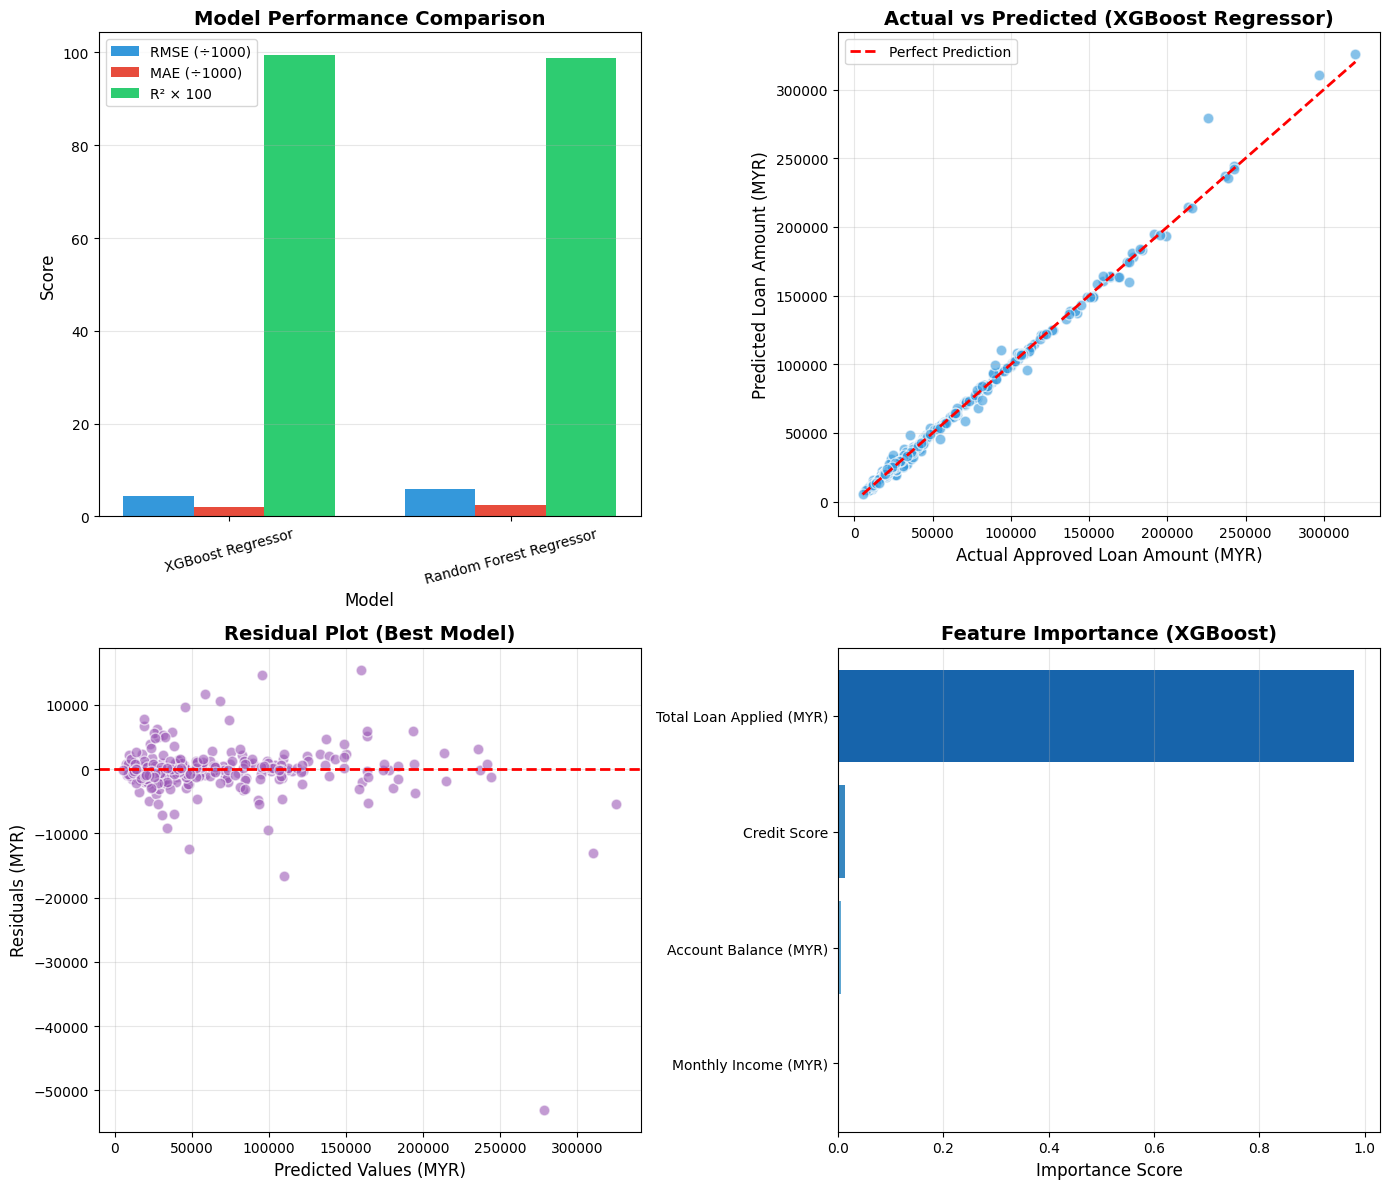

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Bar chart comparing metrics
ax1 = axes[0, 0]
x = np.arange(len(results))
width = 0.25
ax1.bar(x - width, [results[m]['test_rmse']/1000 for m in results], width, label='RMSE (÷1000)', color='#3498db')
ax1.bar(x, [results[m]['test_mae']/1000 for m in results], width, label='MAE (÷1000)', color='#e74c3c')
ax1.bar(x + width, [results[m]['test_r2']*100 for m in results], width, label='R² × 100', color='#2ecc71')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(list(results.keys()), rotation=15) # Dynamically set labels from results keys
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Actual vs Predicted for best model
ax2 = axes[0, 1]
best_preds = results[best_model_name]['predictions']
ax2.scatter(y_test, best_preds, alpha=0.6, c='#3498db', edgecolors='white', s=60)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Approved Loan Amount (MYR)', fontsize=12)
ax2.set_ylabel('Predicted Loan Amount (MYR)', fontsize=12)
ax2.set_title(f'Actual vs Predicted ({best_model_name})', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Residual plot for best model
ax3 = axes[1, 0]
residuals = y_test.values - best_preds
ax3.scatter(best_preds, residuals, alpha=0.6, c='#9b59b6', edgecolors='white', s=60)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Values (MYR)', fontsize=12)
ax3.set_ylabel('Residuals (MYR)', fontsize=12)
ax3.set_title('Residual Plot (Best Model)', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Feature Importance (XGBoost)
ax4 = axes[1, 1]
if 'XGBoost Regressor' in results:
    xgb_model = results['XGBoost Regressor']['model']
    importance = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': FEATURES,
        'Importance': importance
    }).sort_values('Importance', ascending=True)

    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(FEATURES)))
    ax4.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
    ax4.set_xlabel('Importance Score', fontsize=12)
    ax4.set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('loan_model_results.png', dpi=150, bbox_inches='tight')
plt.show()